<a href="https://colab.research.google.com/github/GabrielFePL/Sugestao-de-Noticia-LSTM/blob/main/Estudo02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede Neural Recorrente para Predição de Notícias Sugeridas

## Base de Dados Histórica Simulada

### Importação das Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

### Função de Geração da Base de Dados e Registros

In [128]:
def generate_simulated_data(num_users, num_access, num_subcategories, start_date):
  data = []

  # Definir preferências por subcategorias para cada usuário
  user_preferences = {user_id: random.choices(range(1, num_subcategories+1), k=num_subcategories) for user_id in range(1, num_users+1)}

  # Definir perfil de horário de cada usuário
  user_profile = {user_id: random.choice(['morning', 'afternoon', 'evening', 'night']) for user_id in range(1, num_users+1)}

  morning_hours = list(range(6, 12))
  afternoon_hours = list(range(12, 18))
  evening_hours = list(range(18, 24))
  night_hours = list(range(0, 6))

  accesses_per_user = num_access // num_users

  for i in range(1, num_users + 1):
    user_id = i

    # Ajustar horários com base no perfil do usuário
    profile = user_profile[user_id]
    if profile == 'morning':
      time_slots = morning_hours * 4 + evening_hours * 2 + afternoon_hours * 1 + night_hours * 1
    elif profile == 'afternoon':
      time_slots = afternoon_hours * 4 + evening_hours * 2 + morning_hours * 1 + night_hours * 1
    elif profile == 'evening':
      time_slots = evening_hours * 4 + morning_hours * 2 + afternoon_hours * 1 + night_hours * 1
    else:
      time_slots = night_hours * 4 + evening_hours * 2 + afternoon_hours * 1 + morning_hours * 1

    current_timestamp = start_date

    for r in range(accesses_per_user):
      # Probabilidade maior de acessar subcategorias favoritas
      subcategory_id = random.choices(user_preferences[user_id], weights=[0.4 if sc == user_preferences[user_id][0] else 0.2 for sc in user_preferences[user_id]], k=1)[0]

      # Simulação de horários com mais acessos
      hour_bias = random.choices(time_slots, k=1)[0]
      current_timestamp = current_timestamp.replace(hour=hour_bias, minute=random.randint(0, 59))

      day_of_week = current_timestamp.weekday()
      hour_of_day = current_timestamp.hour

      data.append([user_id, current_timestamp, subcategory_id, day_of_week, hour_of_day])

      current_timestamp += timedelta(days=random.randint(1, 3), hours=random.randint(0, 5))

  columns = ['User_ID', 'Access_Timestamp', 'Subcategory_ID', 'Day_of_Week', 'Hour_of_Day']
  df = pd.DataFrame(data, columns=columns)

  return df

### Geração da Base de Dados

In [129]:
# Definição da Simulação
num_users = 2000
num_accesses = 50000
num_subcategories = 15
start_date = datetime(2023, 7, 24)

# Chamada da Função de Geração
simulated_data = generate_simulated_data(num_users, num_accesses, num_subcategories, start_date)

### Visualização da Base de Dados

In [137]:
simulated_data

,User_ID,Access_Timestamp,Subcategory_ID,Day_of_Week,Hour_of_Day
0,1,2023-07-24 18:29:00,4,0,18
1,1,2023-07-27 21:12:00,1,3,21
2,1,2023-07-29 04:28:00,10,5,4
3,1,2023-07-30 13:12:00,10,6,13
4,1,2023-08-01 01:25:00,9,1,1
...,...,...,...,...,...
49995,2000,2023-08-31 00:19:00,5,3,0
49996,2000,2023-09-03 20:13:00,6,6,20
49997,2000,2023-09-06 02:22:00,8,2,2
49998,2000,2023-09-08 22:29:00,9,4,22


In [138]:
simulated_data.describe()

,User_ID,Access_Timestamp,Subcategory_ID,Day_of_Week,Hour_of_Day
count,50000.000000,50000,50000.000000,50000.000000,50000.000000
mean,1000.500000,2023-08-19 01:55:07.327200,7.970760,2.872720,12.309140
min,1.000000,2023-07-24 00:05:00,1.000000,0.000000,0.000000
25%,500.750000,2023-08-05 15:16:45,4.000000,1.000000,6.000000
50%,1000.500000,2023-08-18 21:36:00,8.000000,3.000000,12.000000
75%,1500.250000,2023-09-01 03:53:00,12.000000,5.000000,19.000000
max,2000.000000,2023-09-29 21:06:00,15.000000,6.000000,23.000000
std,577.355971,NaN,4.321985,2.022939,7.018644


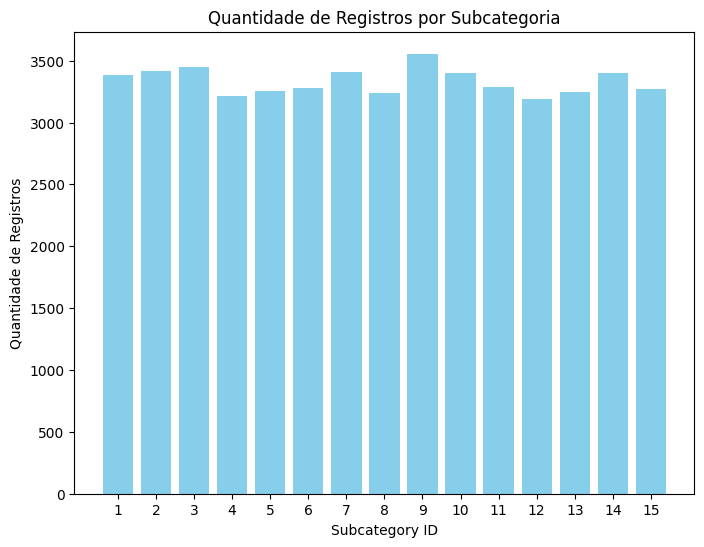

In [139]:
subcategory_counts = simulated_data['Subcategory_ID'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(subcategory_counts.index, subcategory_counts.values, color = 'skyblue')
plt.xlabel('Subcategory ID')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Subcategoria')
plt.xticks(subcategory_counts.index)
plt.show()

### Visualização de Usuário Aleatório

In [140]:
random_user1 = random.randint(1, num_users)
simulated_data[simulated_data['User_ID'] == random_user1]

,User_ID,Access_Timestamp,Subcategory_ID,Day_of_Week,Hour_of_Day
40750,1631,2023-07-24 20:25:00,10,0,20
40751,1631,2023-07-25 03:05:00,1,1,3
40752,1631,2023-07-27 20:29:00,6,3,20
40753,1631,2023-07-28 20:06:00,11,4,20
40754,1631,2023-07-29 12:19:00,1,5,12
40755,1631,2023-08-01 19:02:00,12,1,19
40756,1631,2023-08-04 22:29:00,1,4,22
40757,1631,2023-08-05 18:33:00,7,5,18
40758,1631,2023-08-08 12:21:00,10,1,12
40759,1631,2023-08-09 22:20:00,11,2,22


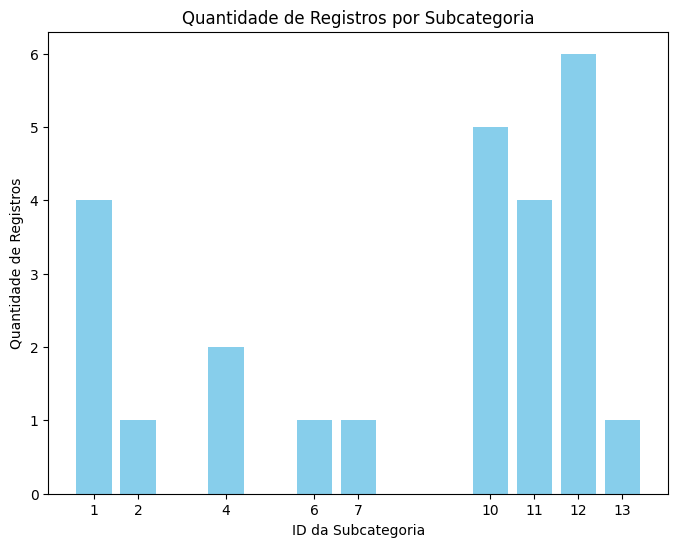

In [141]:
subcategory_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Subcategory_ID'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(subcategory_counts.index, subcategory_counts.values, color = 'skyblue')
plt.xlabel('ID da Subcategoria')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Subcategoria')
plt.xticks(subcategory_counts.index)
plt.show()

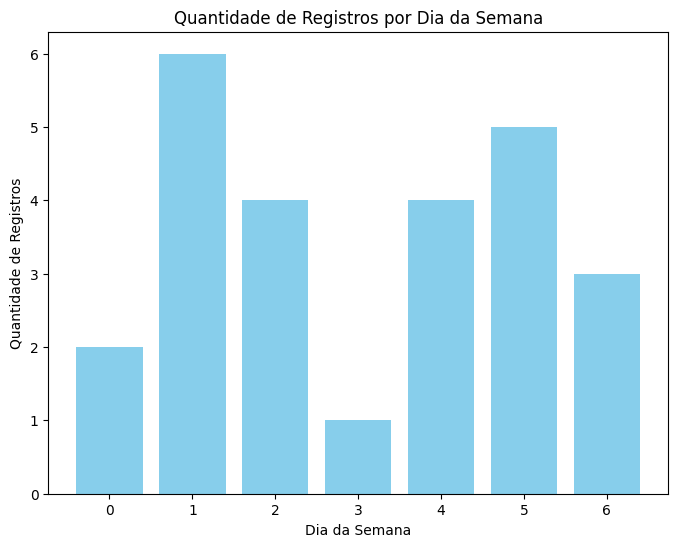

In [142]:
day_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Day_of_Week'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(day_counts.index, day_counts.values, color = 'skyblue')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Dia da Semana')
plt.xticks(day_counts.index)
plt.show()

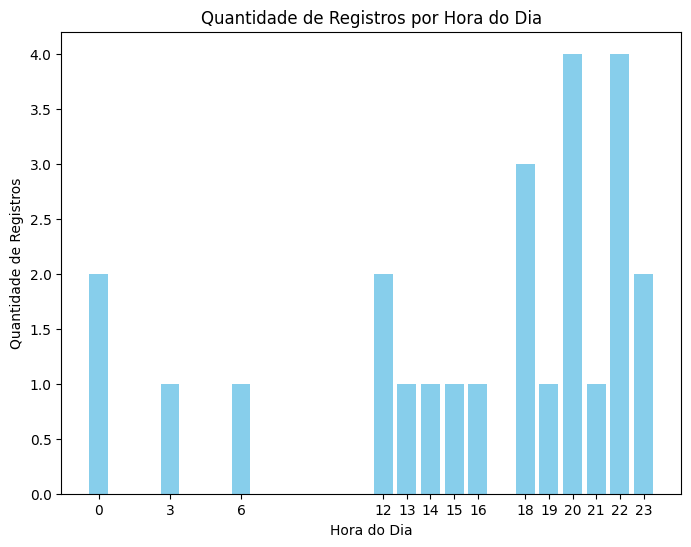

In [143]:
hour_counts = simulated_data[simulated_data['User_ID'] == random_user1]['Hour_of_Day'].value_counts()

plt.figure(figsize = (8, 6))
plt.bar(hour_counts.index, hour_counts.values, color = 'skyblue')
plt.xlabel('Hora do Dia')
plt.ylabel('Quantidade de Registros')
plt.title('Quantidade de Registros por Hora do Dia')
plt.xticks(hour_counts.index)
plt.show()

### Exportação da Base de Dados

In [144]:
simulated_data.to_csv('simulated_data.csv', index = False)

## Tratamento da Base de Dados para Ingestão do Modelo

### Importação das Bibliotecas

In [145]:
!pip install tensorflow

In [146]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [147]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importação da Base de Dados

In [148]:
db = pd.read_csv('/content/simulated_data.csv')
db

,User_ID,Access_Timestamp,Subcategory_ID,Day_of_Week,Hour_of_Day
0,1,2023-07-24 18:29:00,4,0,18
1,1,2023-07-27 21:12:00,1,3,21
2,1,2023-07-29 04:28:00,10,5,4
3,1,2023-07-30 13:12:00,10,6,13
4,1,2023-08-01 01:25:00,9,1,1
...,...,...,...,...,...
49995,2000,2023-08-31 00:19:00,5,3,0
49996,2000,2023-09-03 20:13:00,6,6,20
49997,2000,2023-09-06 02:22:00,8,2,2
49998,2000,2023-09-08 22:29:00,9,4,22


In [149]:
db[db['User_ID'] == 1]

,User_ID,Access_Timestamp,Subcategory_ID,Day_of_Week,Hour_of_Day
0,1,2023-07-24 18:29:00,4,0,18
1,1,2023-07-27 21:12:00,1,3,21
2,1,2023-07-29 04:28:00,10,5,4
3,1,2023-07-30 13:12:00,10,6,13
4,1,2023-08-01 01:25:00,9,1,1
5,1,2023-08-03 19:32:00,1,3,19
6,1,2023-08-06 22:26:00,1,6,22
7,1,2023-08-10 01:13:00,4,3,1
8,1,2023-08-12 15:13:00,9,5,15
9,1,2023-08-15 20:52:00,5,1,20


### Conversão de Datas para Tipos Numéricos

# Descrição dos Estudos

## Resumo do Estudo 01

Ao iniciar as pesquisas sobre o treinamento e a implementação de uma rede neural recorrente (RNN) para rastrear e prever os acessos de usuários às subcategorias de um portal de notícias, descobriu-se que o modelo LSTM é adequado para lidar com dados sequenciais e capturar dependências temporais em longas sequências de dados.
O Estudo 01 teve como intuito estabelecer uma base de dados fictícia adequada para o treinamento do modelo LSTM. Contudo, a base de dados gerada se mostrou ineficaz ao modelo, já que não representa os eventos temporais tão significativamente como deveria.

## Resumo do Estudo 02

Dada a ineficácia da base de dados simulada criada no Estudo 01, o objetivo do Estudo 02 foi gerar uma base de dados eficaz e balanceada para o treinamento do modelo LSTM. Neste Estudo, criou-se uma função para gerar registros aleatórios, porém, com variações probabilísticas em intervalos que representam o padrão de comportamento do usuário. Além de sessões dedicadas à visualização da base de dados e usuários para confirmação de sua eficácia. Mais adiante no Estudo 02, é iniciado o Tratamento da mesma base para a etapa posterior de Ingestão de Dados do modelo.